# PCA / KNN /Scatter Plot Implementation
Below is a pretty lightweight library for performing PCA, KNN, and drawing scatter plots. I will be using the functions below for the two exercises in this assignment.

In [96]:
from sklearn.datasets import load_digits
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import heapq

def centralize(A):
    means = [np.mean(A[r,:]) for r in range(A.shape[0])]
    for r in range(A.shape[0]):
        A[r,:] -= means[r]
    return A
    

def PCA(A, numComponents):
    # First, center the data
    A = centralize(A)
    
    # Now, compute the SVD, and reduce the dimensions of A.
    U, Sigma, Vt = np.linalg.svd(A)
    D = np.matmul(A.T, U[:,:numComponents])
    
    return D.T

def makeScatterPlot(title, pointsLists, colors):
    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
     
    for i, pointsList in enumerate(pointsLists):
        currColor = colors[i]
        for point in pointsList:
            x, y = point
            ax.scatter(x, y, c=currColor)
        
    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
def KNN(images, pointsLists, k):
    """
    Returns a list of classifications of testImages based on the pointsLists and k using KNN.
    """
    result = []
    
    classList = []
    for label, pointsList in enumerate(pointsLists):
        for point in pointsList:
            classList.append( (label, point) )
        
    for c in range(images.shape[1]):
        currPoint = images[:,c]
        maxHeap = []
        for label, point in classList:
            currDistance = np.linalg.norm(currPoint - point)
            currTup = (-currDistance, label, point)
            if len(maxHeap) < k:
                heapq.heappush(maxHeap, currTup)
            elif currDistance < abs(maxHeap[0][0]):
                heapq.heapreplace(maxHeap, currTup)
        table = defaultdict(int)
        for distance, label, point in maxHeap:
            table[label] += 1
        result.append(max(table, key = lambda k: table[k]))
    
    return result



# Problem 1
Below is my implementation to the various exercises given in the first problem.

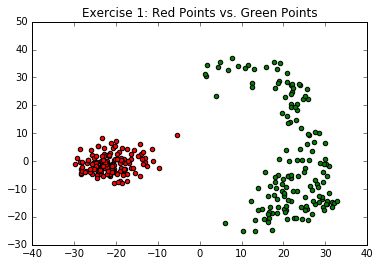

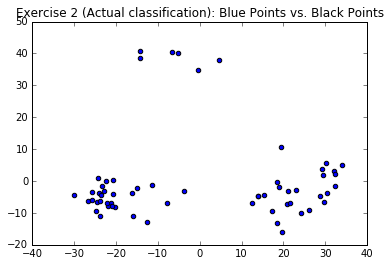

In [97]:
def problem1():
    images, labels = load_digits(2, return_X_y=True)
    
    # Labeled training set (each image is a column)
    trainingImages = images[:300].T
    trainingLabels = labels[:300]
    
    # Labeled test set (each image is a column)
    testImages = images[300:].T
    testLabels = labels[300:]
    
    # First, perform the exercise using PCA with r = 2 and make the scatter plot.
    r = 2
    lowerDimImages = PCA(trainingImages, r)
    redPoints = [lowerDimImages[:,i] for i, label in enumerate(trainingLabels) if label == 0]
    greenPoints = [lowerDimImages[:,i] for i, label in enumerate(trainingLabels) if label == 1]
    title = "Exercise 1: Red Points vs. Green Points"
    pointsLists = [redPoints, greenPoints]
    colors = ['r', 'g']
    makeScatterPlot(title, pointsLists, colors)
    
    # Now, try to label the 2d PCA versions of testImages using KNN on the 2d PCA versions of the
    # training images using KNN with k = 5. Make the colorful scatter plot again.
    k = 5
    lowerDimTestImages = PCA(testImages, r)
    testClassifications = KNN(lowerDimTestImages, pointsLists, k)
    bluePoints = [lowerDimTestImages[:,i] for i, label in enumerate(testLabels) if label == testClassifications[i]]
    blackPoints = [lowerDimTestImages[:,i] for i, label in enumerate(testLabels) if label != testClassifications[i]]
    title = "Exercise 2 (Actual classification): Blue Points vs. Black Points"
    pointsLists = [bluePoints, blackPoints]
    colors = ['blue', 'black']
    makeScatterPlot(title, pointsLists, colors)
    
problem1()



Due to how the testing data was chosen, all of the testing images were classified correctly. Therefore, the error is 0. If there were more images in the test set (and maybe less images in the training set), we would see more errors. However, this seems to be a suboptimal exercise for demonstrating how error in classification works.

# Problem 2
Below is my implementation to the various exercises given in the second problem.

The lowest value that captures 0.95 of the variation between data is 19 components


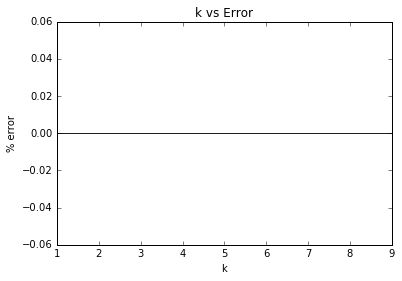

In [99]:
def problem2():
    images, labels = load_digits(2, return_X_y=True)
    
    # Labeled training set (each image is a column)
    trainingImages = images[:300].T
    trainingLabels = labels[:300]
    
    # Labeled test set (each image is a column)
    testImages = images[300:].T
    testLabels = labels[300:]
    
    # Calculate the minimum value of numComponents (I use r for row indices so it's a bad name to use) s.t. the top 
    # numComponents principal components capture 95% of the variation in teh data.
    centralizedImages = centralize(trainingImages)
    U, Sigma, Vt = np.linalg.svd(centralizedImages)
    minVariation = 0.95
    for numComponents in range(Sigma.shape[0]):
        currVal = sum([np.square(x) for x in Sigma[:numComponents]]) / np.square(np.linalg.norm(centralizedImages))
        if currVal >= minVariation: break
    print "The lowest value that captures {} of the variation between data is {} components".format(minVariation, numComponents)

    # First perform PCA to numComponents dimensions and then do KNN classification.
    lowerImages = PCA(trainingImages, numComponents)
    zeroPoints = [lowerImages[:,i] for i, label in enumerate(trainingLabels) if label == 0]
    onePoints = [lowerImages[:,i] for i, label in enumerate(trainingLabels) if label == 1]
    pointsLists = [zeroPoints, onePoints]
    lowerTestImages = PCA(testImages, numComponents)
    
    # Plot the errors for odd k between 1 and 9
    K = [k for k in range(1, 10, 2)]
    errors = []
    for k in K:
        obtainedLabels = KNN(lowerTestImages, pointsLists, k)
        numCorrect = len([1 for i in range(len(testLabels)) if testLabels[i] == obtainedLabels[i]])
        numIncorrect = len(testLabels) - numCorrect
        errors.append(float(numIncorrect) / len(testLabels))
    plt.plot(K, errors)
    plt.title("k vs Error")
    plt.xlabel("k")
    plt.ylabel("% error")
    
problem2()
    
    

Well, this plot isn't very interesting because the data chosen wasn't the best (see above for more explanation of that). Based solely off of this graph, I would say any k would work, but in practice there would need to be a balance between k being too big and k being too small, so I would guess somewhere in the middle?